In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D

import tqdm

from aocd import get_data

In [2]:
data = get_data()

In [3]:
#data = '''3,8,1001,8,10,8,105,1,0,0,21,34,51,76,101,114,195,276,357,438,99999,3,9,1001,9,3,9,1002,9,3,9,4,9,99,3,9,101,4,9,9,102,4,9,9,1001,9,5,9,4,9,99,3,9,1002,9,4,9,101,3,9,9,102,5,9,9,1001,9,2,9,1002,9,2,9,4,9,99,3,9,1001,9,3,9,102,2,9,9,101,4,9,9,102,3,9,9,101,2,9,9,4,9,99,3,9,102,2,9,9,101,4,9,9,4,9,99,3,9,102,2,9,9,4,9,3,9,102,2,9,9,4,9,3,9,1001,9,1,9,4,9,3,9,1001,9,2,9,4,9,3,9,101,2,9,9,4,9,3,9,1002,9,2,9,4,9,3,9,1002,9,2,9,4,9,3,9,1001,9,2,9,4,9,3,9,1002,9,2,9,4,9,3,9,101,2,9,9,4,9,99,3,9,101,2,9,9,4,9,3,9,1002,9,2,9,4,9,3,9,1001,9,1,9,4,9,3,9,1001,9,1,9,4,9,3,9,1002,9,2,9,4,9,3,9,102,2,9,9,4,9,3,9,101,1,9,9,4,9,3,9,1002,9,2,9,4,9,3,9,1001,9,2,9,4,9,3,9,1001,9,2,9,4,9,99,3,9,1001,9,2,9,4,9,3,9,102,2,9,9,4,9,3,9,101,2,9,9,4,9,3,9,102,2,9,9,4,9,3,9,1001,9,1,9,4,9,3,9,102,2,9,9,4,9,3,9,1001,9,1,9,4,9,3,9,102,2,9,9,4,9,3,9,1002,9,2,9,4,9,3,9,101,2,9,9,4,9,99,3,9,102,2,9,9,4,9,3,9,102,2,9,9,4,9,3,9,1002,9,2,9,4,9,3,9,1001,9,1,9,4,9,3,9,1002,9,2,9,4,9,3,9,102,2,9,9,4,9,3,9,1001,9,2,9,4,9,3,9,101,1,9,9,4,9,3,9,102,2,9,9,4,9,3,9,102,2,9,9,4,9,99,3,9,1002,9,2,9,4,9,3,9,101,2,9,9,4,9,3,9,101,1,9,9,4,9,3,9,101,2,9,9,4,9,3,9,101,1,9,9,4,9,3,9,1001,9,2,9,4,9,3,9,1002,9,2,9,4,9,3,9,1001,9,1,9,4,9,3,9,1001,9,2,9,4,9,3,9,1002,9,2,9,4,9,99'''
state = list(map(int, data.split(',')))

In [4]:
from operator import add, mul
from queue import SimpleQueue

PC_STEP = {1: 4, 2: 4, 3: 2, 4: 2, 5: 3, 6: 3, 7: 4, 8: 4, 9:2}

class HaltException(Exception):
    pass

class Computer:
    def __init__(self, state):
        self.state = {i:v for i,v in enumerate(state)}
        self.pc = 0
        self.rel_base = 0
        self.inputs = SimpleQueue()
        
    def set_output(self, pc, mode, value):
        if value is None:
            raise ValueError
        pointer = self.state.setdefault(pc, 0)
        if mode==2:
            self.state[pointer + self.rel_base] = value
        else:
            self.state[pointer] = value
            
    def eval(self):
        """
        Evaluates program state until output is generated.
        Blocks if input is exhausted.
        """
        while True:
            instr = str(self.state.setdefault(self.pc,0))
            opcode = int(instr[-2:])
            if opcode == 99:
                raise HaltException

            # parameter modes
            modes = []
            for i in range(3, PC_STEP[opcode] + 2):
                if len(instr) >= i:
                    modes.append(int(instr[-i]))
                else:
                    modes.append(0)

            # deference params, if applicable
            params = []
            for i in range(1, PC_STEP[opcode]):
                loc = self.state.setdefault(self.pc+i, 0)
                if modes[i - 1] == 0:  # position
                    params.append(self.state.setdefault(loc, 0))
                elif modes[i - 1] == 1:  # immediate
                    params.append(loc)
                else:
                    params.append(self.state.setdefault(loc+self.rel_base, 0))

            if opcode == 4:  # output
                # nb: special case, returns
                self.pc += 2
                return params[0]
            elif opcode == 1 or opcode == 2:  # add/mul
                op = add if opcode == 1 else mul
                self.set_output(self.pc + 3, modes[2], op(params[0],params[1]))
            elif opcode == 3:  # input
                inp = self.inputs.get()
                #print(inp)
                self.set_output(self.pc + 1, modes[0], inp)
            elif opcode == 5:  # jmp 0
                if params[0] != 0:
                    self.pc = params[1]
                    continue
            elif opcode == 6:  # jmp not 0
                if params[0] == 0:
                    self.pc = params[1]
                    continue
            elif opcode == 7:  # less than
                self.set_output(self.pc+3, modes[2], 1 if params[0] < params[1] else 0)
            elif opcode == 8:  # equals
                self.set_output(self.pc+3, modes[2], 1 if params[0] == params[1] else 0)
            elif opcode == 9:
                self.rel_base += params[0]
            else:
                raise ValueError
            self.pc += PC_STEP[opcode]
            #print(c.state.get(1103, -1))

    def put(self, obj):
        """Add an input to the queue"""
        self.inputs.put(obj)

In [5]:
def compute_direction(cur_loc, bac_loc):
    if bac_loc[1]-cur_loc[1]==1:
        return 1
    elif bac_loc[1]-cur_loc[1]==-1:
        return 2
    elif bac_loc[0]-cur_loc[0]==1:
        return 4
    elif bac_loc[0]-cur_loc[0]==-1:
        return 3
    else:
        raise ValueError

In [6]:
def create_neighbour_directions(cur_loc):
    xpos, ypos = cur_loc
    return [
        [1, (xpos, ypos+1)],
        [2, (xpos, ypos-1)],
        [3, (xpos-1, ypos)],
        [4, (xpos+1, ypos)]
    ]

In [23]:
explored = {}
cur_loc = (0,0)
explored[cur_loc] = [1, False]
c = Computer(state)

for cnt in range(300_000):
    if cnt%10_000==0:
        print(cnt)
    for direc, pot_loc in create_neighbour_directions(cur_loc):
        #print('pot_loc:',pot_loc)
        if pot_loc not in explored:
            #print(pot_loc, 'unexplored')
            c.put(direc)
            resp = c.eval()
            explored[pot_loc] = [resp, False]
            if resp > 0:
                cur_loc = pot_loc
                # print('cur_loc:',cur_loc)
                break
    else:
        explored[cur_loc][1] = True
        for _, back_loc in create_neighbour_directions(cur_loc):
            code, fully = explored[back_loc]
            if code == 1 and not fully:
                break
        else:
            raise ValueError('impossible!')
        # print(back_loc)
        direc = compute_direction(cur_loc, back_loc)
        c.put(direc)
        r = c.eval()
        assert r==1
        cur_loc = back_loc

0


ValueError: impossible!

In [44]:
explored[(14,-14)]

[2, True]

In [54]:
src = (14,-14)
max_p = 0
for k, (c, _) in explored.items():
    if c == 0:
        continue
    p = nx.shortest_path_length(G, src, k)
    if p > max_p:
        max_p = p

In [55]:
max_p

406

In [46]:
import networkx as nx

In [47]:
G = nx.Graph()

In [48]:
for n, (c, _) in explored.items():
    if c>0:
        G.add_node(n)


In [49]:
for n in G.nodes:
    for _, nn in create_neighbour_directions(n):
        if nn in G.nodes:
            G.add_edge(n, nn)

In [22]:
len(nx.shortest_path(G, (0,0), (14,-14))) - 1

404

In [25]:
tunnels = [n + (int(explored[n][0]),) for n in explored.keys()]

ar = np.asarray(tunnels)

In [26]:
import matplotlib.pyplot as plt

(-20, 22)

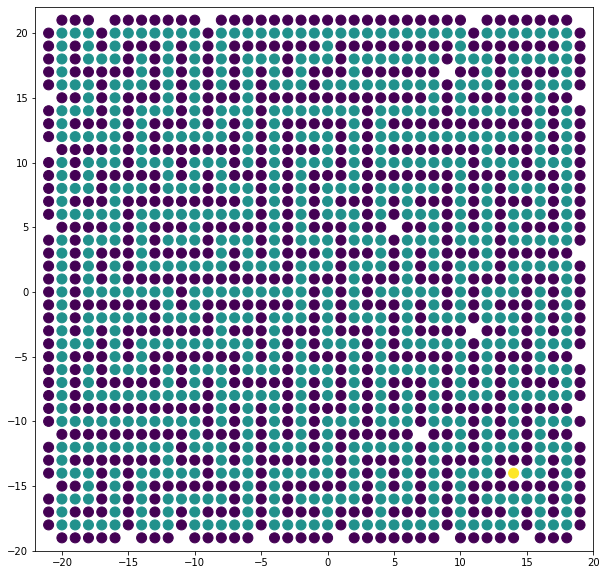

In [35]:
plt.figure(figsize=(10, 10))
plt.scatter(ar[:,0],ar[:,1],c=ar[:,2], s=100)
plt.xlim(-22, 20)
plt.ylim(-20, 22)

In [19]:
c.put(2)

In [21]:
c.eval()

KeyboardInterrupt: 